In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import numpy as np
import Bio

import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

In [3]:
train_seq_path = os.path.join('..', 'data', 'train_sequences.csv')
train_seq = pd.read_csv(train_seq_path)
train_seq = train_seq[['target_id', 'sequence']]


train_labels_path = os.path.join('..', 'data', 'train_labels.csv')
train_labels = pd.read_csv(train_labels_path)

In [4]:
print(train_seq.shape)
train_seq.head()

(844, 2)


,target_id,sequence
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC
1,1RNK_A,GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU
2,1RHT_A,GGGACUGACGAUCACGCAGUCUAU
3,1HLX_A,GGGAUAACUUCGGUUGUCCC
4,1HMH_E,GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU


In [5]:
train_labels.head()

,ID,resname,resid,x_1,y_1,z_1
0,1SCL_A_1,G,1,13.760,-25.974001,0.102
1,1SCL_A_2,G,2,9.310,-29.638000,2.669
2,1SCL_A_3,G,3,5.529,-27.813000,5.878
3,1SCL_A_4,U,4,2.678,-24.900999,9.793
4,1SCL_A_5,G,5,1.827,-20.136000,11.793


Los datos de entrenamiento constan de dos archivos principales:
- `train_seq`: Contiene la secuencia del RNA cuya estructura tridimensional se desea predecir.
- `train_labels`: Contiene las posiciones de cada nucleótido en la secuencia, que es lo que se quiere predecir en nuevas estructuras de RNA.

También es importante notar que tenemos 844 sequencias de entrenamiento.

In [6]:
# Calcular el len de las secuencias
train_seq['sequence'] = train_seq['sequence'].apply(str.strip)
train_seq['sequence_lenght'] = train_seq['sequence'].apply(len)
train_seq = train_seq.replace([np.inf, -np.inf], np.nan)
train_seq.isna().sum()

target_id          0
sequence           0
sequence_lenght    0
dtype: int64

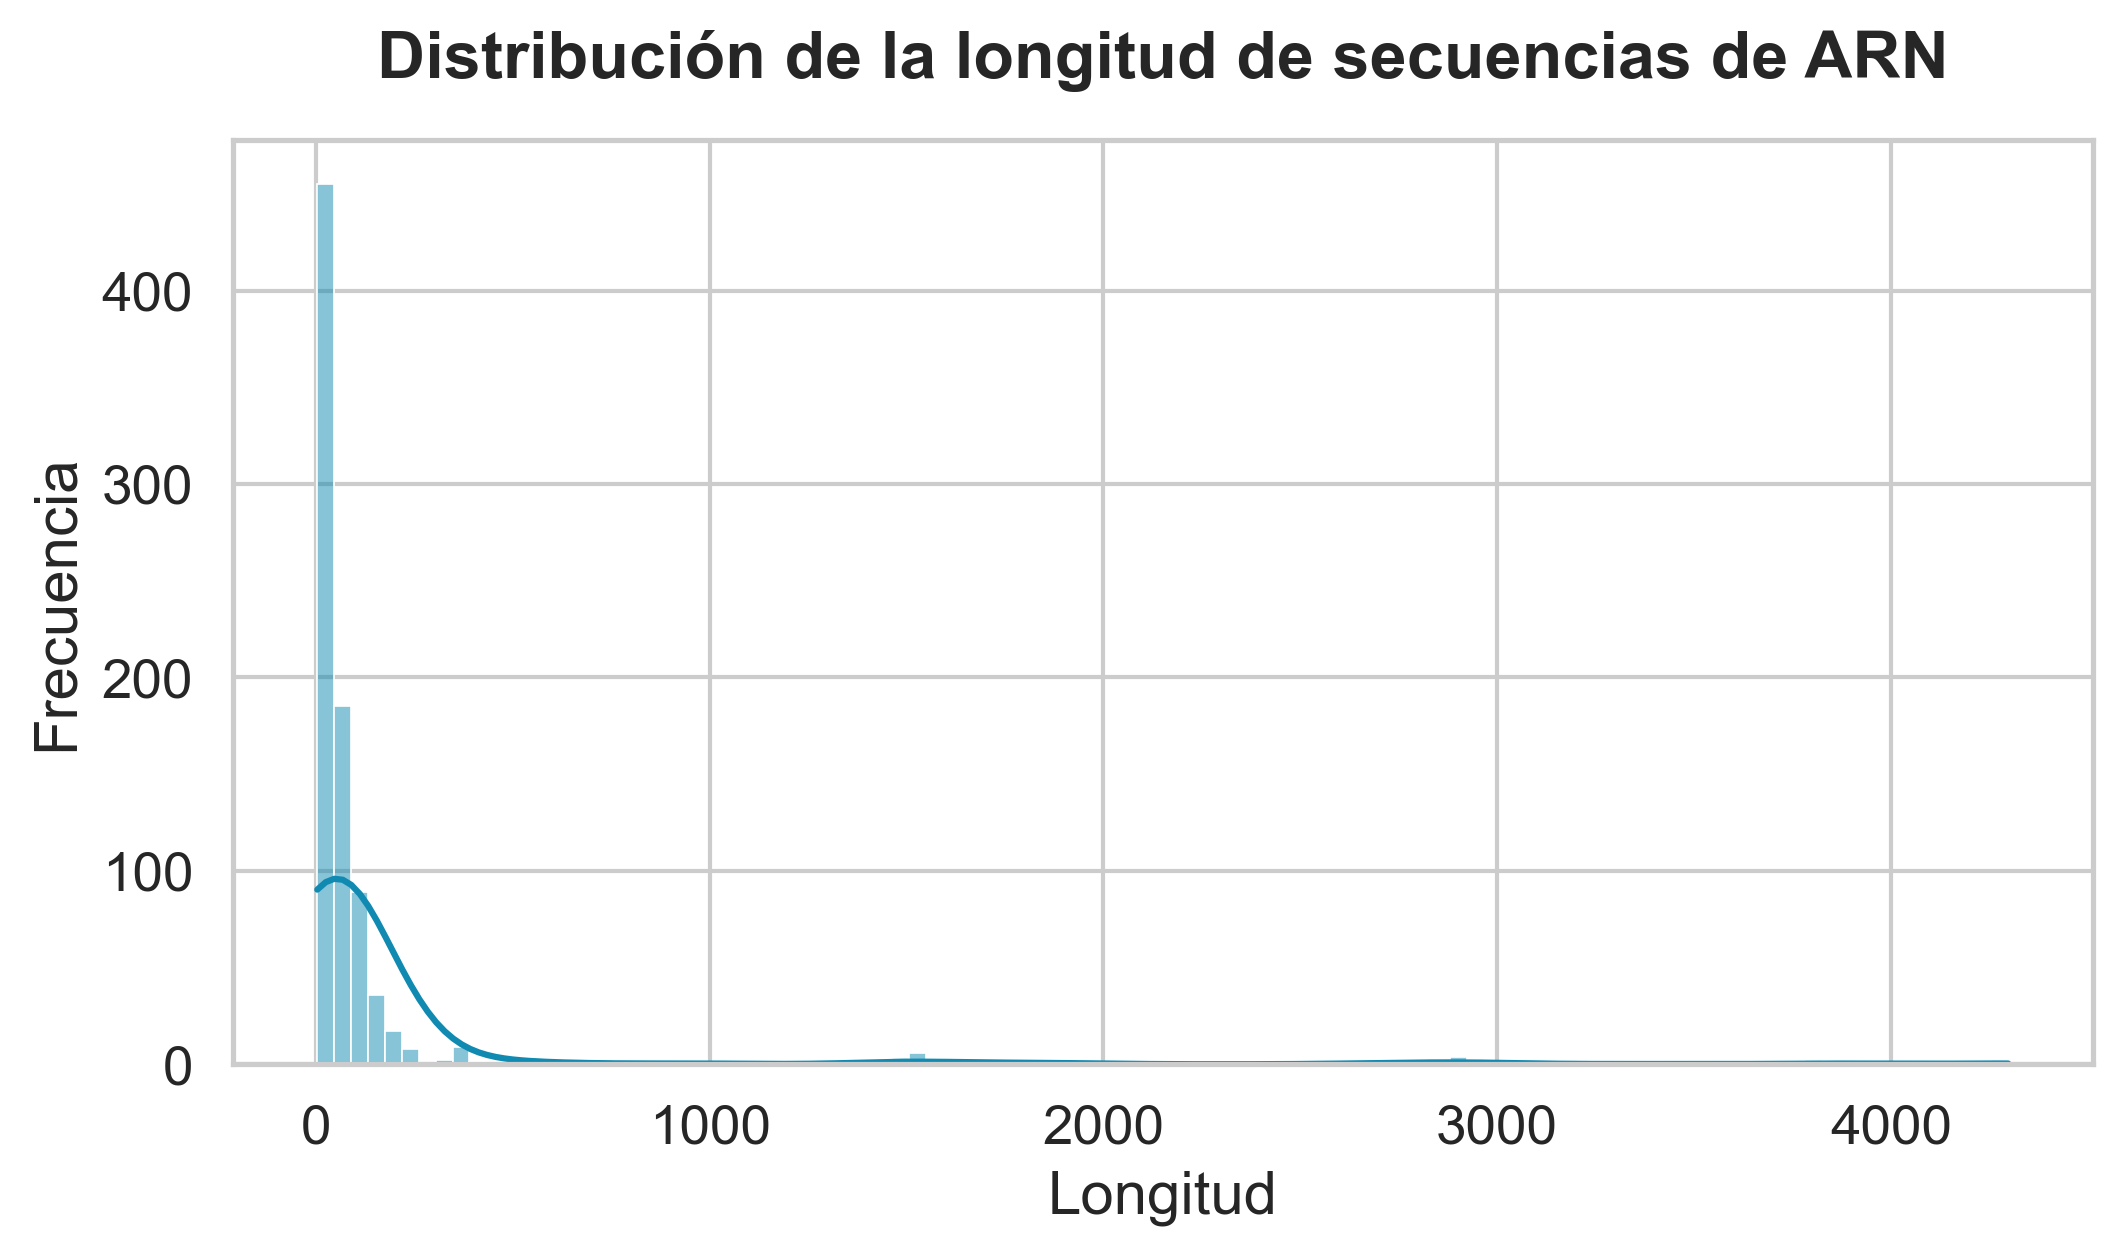

In [7]:
plt.figure(figsize=(8,4), dpi= 300)
sns.histplot(data= train_seq, 
             x= 'sequence_lenght', 
             kde= True, 
             bins= 100, 
             color='#118AB2', 
             edgecolor='white')
plt.title('Distribución de la longitud de secuencias de ARN', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.show()

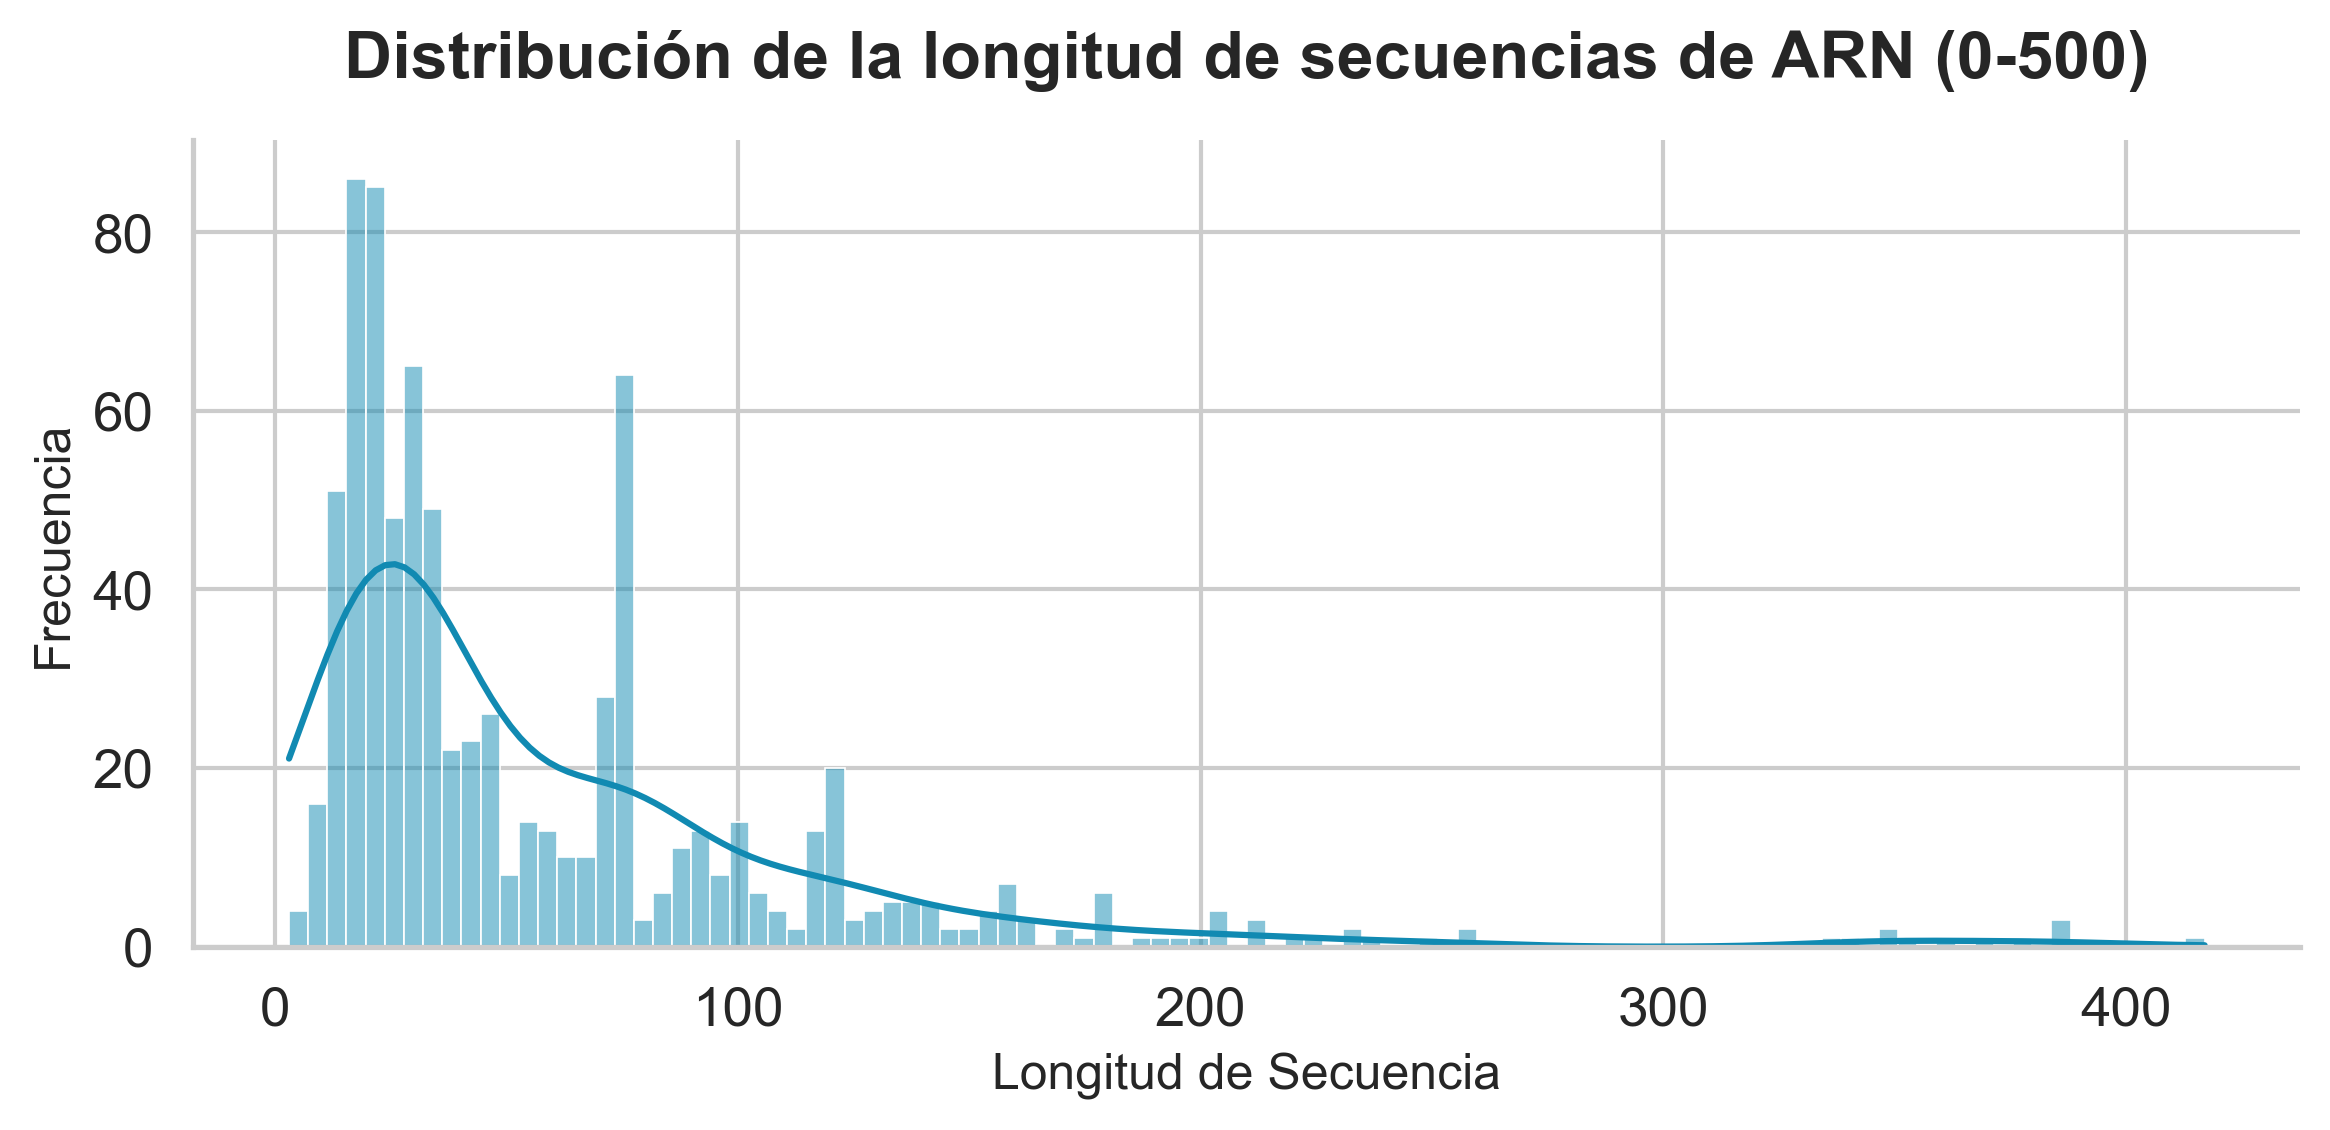

In [8]:

filtered_data = train_seq[train_seq['sequence_lenght'] <= 500]

plt.figure(figsize=(8, 4), dpi=300)
sns.histplot(
    data=filtered_data,
    x='sequence_lenght',
    kde=True,
    bins=100,
    color='#118AB2',
    edgecolor='white'
)
plt.title('Distribución de la longitud de secuencias de ARN (0-500)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Longitud de Secuencia', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

In [9]:
print(f"Secuencia más larga: {max(train_seq['sequence_lenght'])}")

Secuencia más larga: 4298


In [22]:
def nucleotide_dist(seq):
    return pd.Series({
        'A': seq.count('A')/len(seq),
        'U': seq.count('U')/len(seq),
        'G': seq.count('G')/len(seq),
        'C': seq.count('C')/len(seq),
    })

In [23]:
nucleotide_dist(train_seq['sequence'].values[67])

A    0.188525
U    0.147541
G    0.319672
C    0.344262
dtype: float64

In [24]:
train_seq['sequence'].values[67]

'UUAGGCGGCCACAGCGGUGGGGUUGCCUCCCGUACCCAUCCCGAACACGGAAGAUAAGCCCACCAGCGUUCCGGGGAGUACUGGAGUGCGCGAGCCUCUGGGAAACCCGGUUCGCCGCCACC'

In [25]:
nucleotide_freq = train_seq['sequence'].apply(nucleotide_dist)

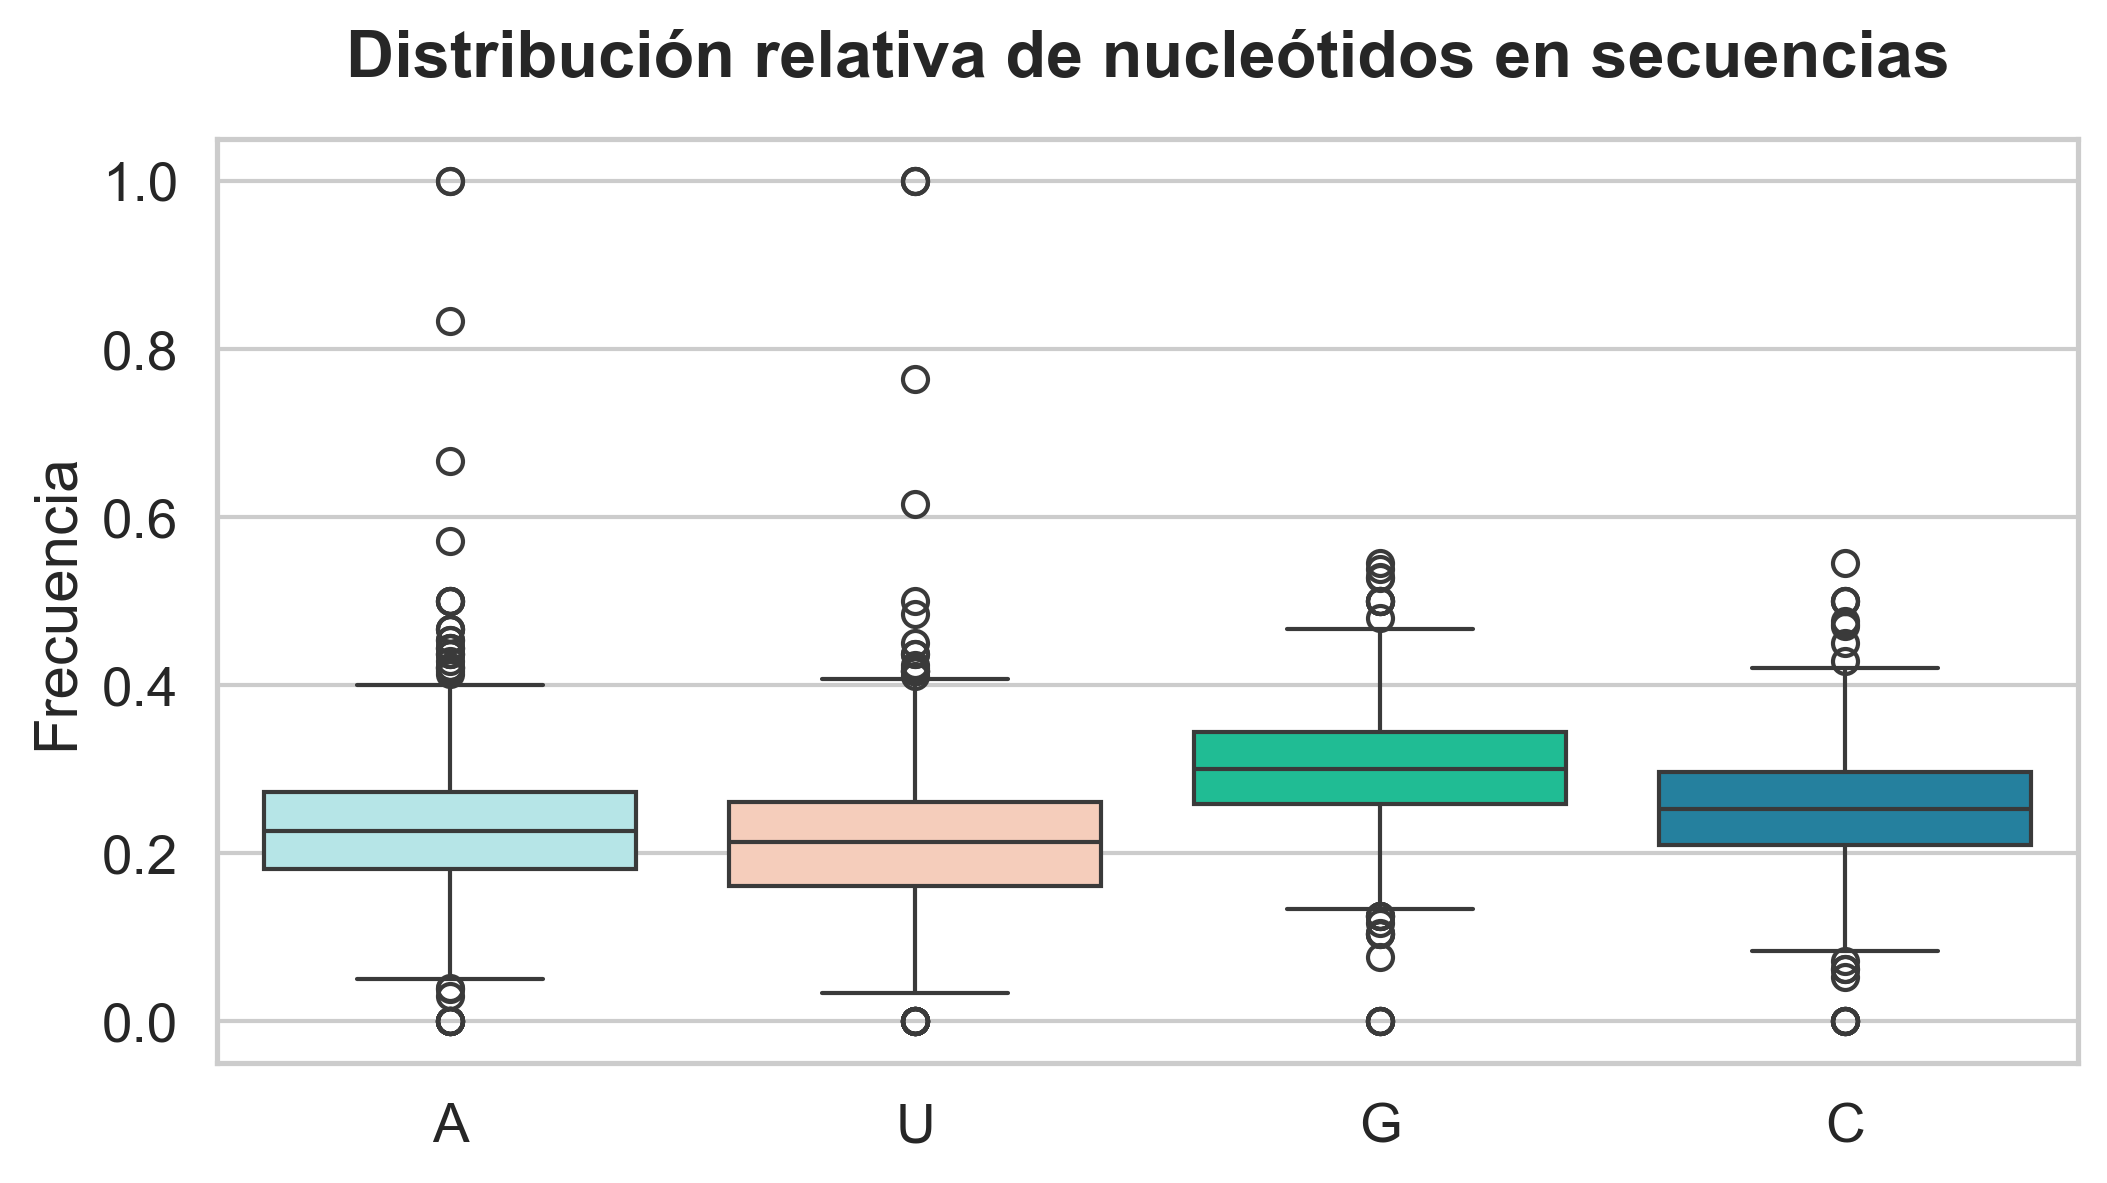

In [37]:
colors = ['#AEECEF', '#FFCAB1', '#06D6A0', '#118AB2']
plt.figure(figsize= (8,4), dpi= 300)
sns.boxplot(data= nucleotide_freq, palette= colors)
plt.title('Distribución relativa de nucleótidos en secuencias', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Frecuencia')
plt.show()

Podemos ver que hay algunos outliers que contienen únicamente Adeninas (A) y Uracilos (U). Es importante analizar estos casos para determinar si deben ser excluidos de nuestras muestras de entrenamiento. Esto permitiría reducir la longitud de la secuencia más larga, con el fin de obtener una arquitectura más estable al momento de modelar una red neuronal.